In [1]:
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 1.0 MB 674 kB/s eta 0:00:01
     |████████████████████████████████| 136 kB 1.7 MB/s eta 0:00:01


In [3]:
from tensorflow import keras
import numpy as np
from functions import build_model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [81]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [86]:
row_size = X_train_full[0].shape[0]
col_size = X_train_full[0].shape[1]

In [95]:
X_train_full = X_train_full.reshape(X_train_full.shape[0],row_size, col_size,1)
X_test = X_test.reshape(X_test.shape[0],row_size, col_size,1)
#y_train_full.reshape(X_train_full.shape[0],row_size, col_size,1)

In [96]:
#dividindo por 255 para escalar os pixels entre 0 e 1
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] /255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## Arquitetura

Uma arquitetura comum para CNN's é: pilha de convolutional layers, seguida por uma ReLU layer, pooling layer, e mais algumas convolutional layers (seguido por ReLU). Uma rede convolucional pode ser definida abaixo:

In [106]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

* A primeira layer usa 64 filtros, cada um 7x7, com função de ativação ReLU, padding same, e o shape do input (imagens 28x28, com um canal de cor)
* Pooling layer que divide as dimensões por 2
* Depois, a repetição de duas layers convolucionais seguidas de uma pooling layer. Para imagens maiores, isso poderia ser repetido mais vezes. O número de repetições é um hiperparametro.
* Por fim, duas hidden dense layers e uma output layer, além das dropout layers para reduzir overfitting.

Obs:
- o número de filtros das layers convolucionais aumenta a medida que crescemos a CNN, isso tem a ver com o número de combinações que podemos fazer com cada imagem de baixo nível
- padding 'same' que significa que a rede convolucional utiliza zero padding se necessário (adicionaria zeros ao dataset caso a output layer seja menor que a input layer, por causa do stride). O padding poderia ser 'valid', que nessa situação ao invés de adicionar zero, ignoraria algumas colunas e linhas da input layer

In [107]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)             

In [109]:
from keras.optimizers import SGD
custom_optimizer = SGD(lr = 0.05)
model.compile(loss="sparse_categorical_crossentropy", optimizer=custom_optimizer, metrics=["accuracy"])

In [110]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
1719/1719 [==============================] - 241s 134ms/step - loss: 0.9626 - accuracy: 0.6719
Epoch 2/15
1719/1719 [==============================] - 230s 134ms/step - loss: 0.1638 - accuracy: 0.9565
Epoch 3/15
1719/1719 [==============================] - 249s 145ms/step - loss: 0.1109 - accuracy: 0.9719
Epoch 4/15
1719/1719 [==============================] - 228s 133ms/step - loss: 0.0834 - accuracy: 0.9783
Epoch 5/15
1719/1719 [==============================] - 214s 125ms/step - loss: 0.0750 - accuracy: 0.9813
Epoch 6/15
1719/1719 [==============================] - 234s 136ms/step - loss: 0.0585 - accuracy: 0.9842
Epoch 7/15
1719/1719 [==============================] - 198s 115ms/step - loss: 0.0543 - accuracy: 0.9862
Epoch 8/15
1719/1719 [==============================] - 198s 115ms/step - loss: 0.0429 - accuracy: 0.9892
Epoch 9/15
1719/1719 [==============================] - 201s 117ms/step - loss: 0.0433 - accuracy: 0.9882
Epoch 10/15
1719/1719 [=======================

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

df_losses = pd.DataFrame(history.history)
df_losses

,loss,accuracy
0,0.493601,0.844855
1,0.147992,0.960727
2,0.106821,0.972618
3,0.083888,0.978909
4,0.070596,0.981764
5,0.059698,0.984327
6,0.055342,0.986236
7,0.047953,0.988418
8,0.043914,0.988655
9,0.040682,0.989200


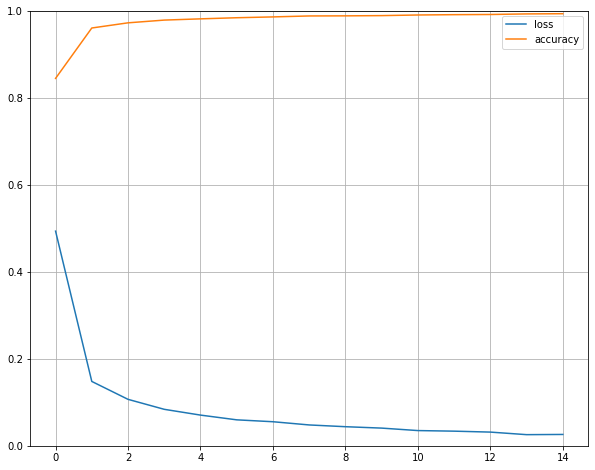

In [112]:
df_losses.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

<AxesSubplot:>

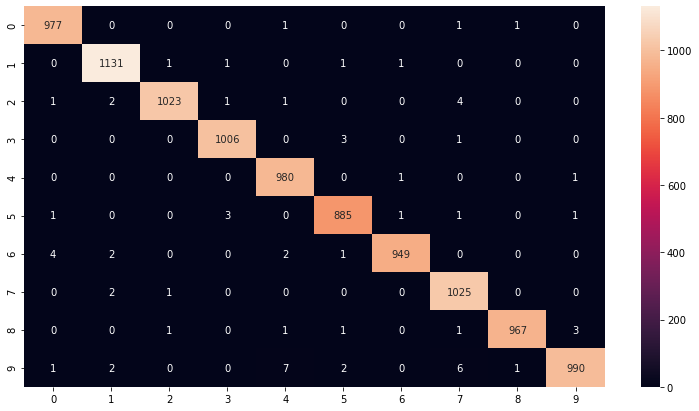

In [113]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

#traditional confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

plt.figure(figsize = (13,7))
sns.heatmap(df_cm, annot=True, fmt='d')

<AxesSubplot:>

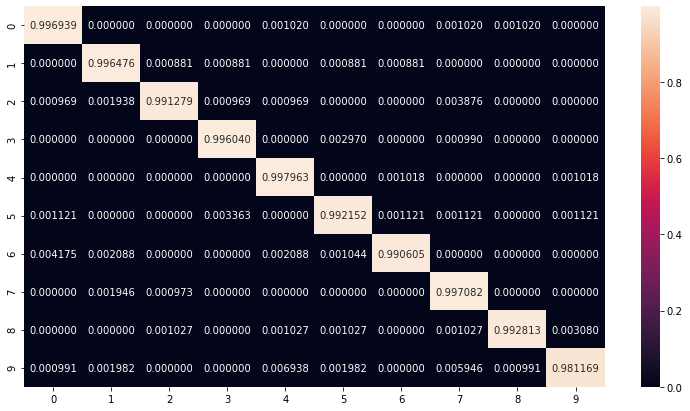

In [114]:
#confusion matrix in accuracy format for each class
cm = confusion_matrix(y_test, y_pred)

df_cm_acc = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

plt.figure(figsize = (13,7))
sns.heatmap(df_cm_acc, annot=True, fmt='f')